## Mixture of log likelihood model, sample train

In [7]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import LatentSchemeGenerator as LSG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width

N_MIX = 100 # is this mix number too large?

EPOCHS = 3000
SAMPLE_AMOUNT = 5000
BATCH_SIZE = 100
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
latent_scheme = LSG.MMNL_generator(N_prod, N_MIX)

mix_para = np.load('EXP11_dump/MMNL_mix_para.npy')
choose_para = np.load('EXP11_dump/MMNL_chos_para.npy')

latent_scheme.mixture_para = mix_para
latent_scheme.choose_para = choose_para


# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # abundant generation
    assort = AG.GenAssortment_Abundant(N_prod)
        
    INPUT[i] = AG.Product_0(assort)
    
    # use decision sample
    OUTPUT[i] = latent_scheme.gen_final_choice(assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

model = Models.Bottleneck(Vec_Len, Neck_Len)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = []
vali_losses = []

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        training_losses.append(loss_pure)
        
    for step, (VALI_IN, TEST) in enumerate(vali_loader):

        VALI_OUT = model(VALI_IN)
        
        VALI_IN = VALI_IN.detach().numpy()[:,1:]
        
        VALI_TEST = np.zeros((len(VALI_IN),Vec_Len))
        
        for i in range(len(VALI_IN)):
            
            VALI_TEST[i] = latent_scheme.gen_final_choice(VALI_IN[i])
            
        VALI_TEST =torch.Tensor(VALI_TEST)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = np.mean(torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy())
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP11-sample_dump/bottleneck_train_loss', training_losses)
np.save('EXP11-sample_dump/bottleneck_vali_loss', vali_losses)
torch.save(model, "EXP11-sample_dump/bottleneck_model.pth")

data generated!
total time elapse :  1.0376570224761963
epoch :  50
epoch :  100
epoch :  150
epoch :  200
epoch :  250
epoch :  300
epoch :  350
epoch :  400
epoch :  450
epoch :  500
epoch :  550
epoch :  600
epoch :  650
epoch :  700
epoch :  750
epoch :  800
epoch :  850
epoch :  900
epoch :  950
epoch :  1000
epoch :  1050
epoch :  1100
epoch :  1150
epoch :  1200
epoch :  1250
epoch :  1300
epoch :  1350
epoch :  1400
epoch :  1450
epoch :  1500
epoch :  1550
epoch :  1600
epoch :  1650
epoch :  1700
epoch :  1750
epoch :  1800
epoch :  1850
epoch :  1900
epoch :  1950
epoch :  2000
epoch :  2050
epoch :  2100
epoch :  2150
epoch :  2200
epoch :  2250
epoch :  2300
epoch :  2350
epoch :  2400
epoch :  2450
epoch :  2500
epoch :  2550
epoch :  2600
epoch :  2650
epoch :  2700
epoch :  2750
epoch :  2800
epoch :  2850
epoch :  2900
epoch :  2950
epoch :  3000


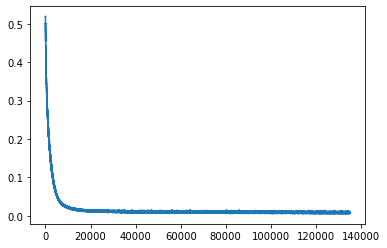

In [8]:
train_loss = np.load('EXP11-sample_dump/bottleneck_train_loss.npy')
plt.plot(train_loss)

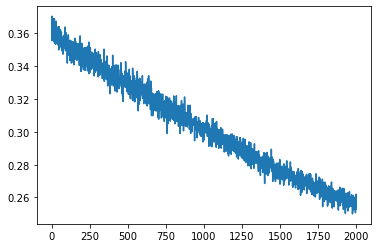

In [10]:
train_loss = np.load('EXP11-sample_dump/bottleneck_vali_loss.npy')
plt.plot(train_loss[1000:])

## histogram test

(array([3.47472e+05, 6.78600e+03, 8.92200e+03, 1.68840e+04, 1.07871e+05,
        4.58000e+02, 3.78000e+02, 3.35000e+02, 2.91000e+02, 1.26030e+04]),
 array([5.123206e-12, 2.000000e-01, 4.000000e-01, 6.000000e-01,
        8.000000e-01, 1.000000e+00, 1.200000e+00, 1.400000e+00,
        1.600000e+00, 1.800000e+00, 2.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

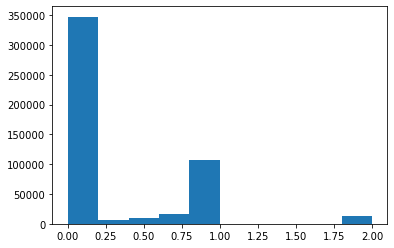

In [14]:
N_prod = 250        # number of products
Vec_Len = N_prod + 1

SAMPLE_AMOUNT = 2000

model = torch.load("EXP11-sample_dump/bottleneck_model.pth")
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 3/10)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = latent_scheme.prob_for_assortment(assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)

## second train

In [15]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import LatentSchemeGenerator as LSG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250        # number of products
Vec_Len = N_prod + 1
Neck_Len = 30       # bottle neck width

N_MIX = 100 # is this mix number too large?

EPOCHS = 3000
SAMPLE_AMOUNT = 5000
BATCH_SIZE = 100
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
latent_scheme = LSG.MMNL_generator(N_prod, N_MIX)

mix_para = np.load('EXP11_dump/MMNL_mix_para.npy')
choose_para = np.load('EXP11_dump/MMNL_chos_para.npy')

latent_scheme.mixture_para = mix_para
latent_scheme.choose_para = choose_para


# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    idx = np.random.uniform(low = 0,high = 1)
    if idx > 0.9:
        assort = assort = AG.GenAssortment_Fixed(N_prod,N_prod)
    else:
        assort = AG.GenAssortment_Fixed(N_prod,N_prod-1)  
        
    INPUT[i] = AG.Product_0(assort)
    
    # use decision sample
    OUTPUT[i] = latent_scheme.gen_final_choice(assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

model = Models.Bottleneck(Vec_Len, Neck_Len)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = []
vali_losses = []

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        training_losses.append(loss_pure)
        
    for step, (VALI_IN, TEST) in enumerate(vali_loader):

        VALI_OUT = model(VALI_IN)
        
        VALI_IN = VALI_IN.detach().numpy()[:,1:]
        
        VALI_TEST = np.zeros((len(VALI_IN),Vec_Len))
        
        for i in range(len(VALI_IN)):
            
            VALI_TEST[i] = latent_scheme.gen_final_choice(VALI_IN[i])
            
        VALI_TEST =torch.Tensor(VALI_TEST)
        
        RELATIVE_LOSS = nn.functional.l1_loss(VALI_TEST, VALI_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(VALI_TEST, min = 1/Vec_Len)

        losses = np.mean(torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=4).detach().numpy())
        
        vali_losses = np.append(vali_losses,losses)

np.save('EXP11-sample_dump/bottleneck_train_loss_second', training_losses)
np.save('EXP11-sample_dump/bottleneck_vali_loss_second', vali_losses)
torch.save(model, "EXP11-sample_dump/bottleneck_model_second.pth")

data generated!
total time elapse :  1.301995038986206
epoch :  50
epoch :  100
epoch :  150
epoch :  200
epoch :  250
epoch :  300
epoch :  350
epoch :  400
epoch :  450
epoch :  500
epoch :  550
epoch :  600
epoch :  650
epoch :  700
epoch :  750
epoch :  800
epoch :  850
epoch :  900
epoch :  950
epoch :  1000
epoch :  1050
epoch :  1100
epoch :  1150
epoch :  1200
epoch :  1250
epoch :  1300
epoch :  1350
epoch :  1400
epoch :  1450
epoch :  1500
epoch :  1550
epoch :  1600
epoch :  1650
epoch :  1700
epoch :  1750
epoch :  1800
epoch :  1850
epoch :  1900
epoch :  1950
epoch :  2000
epoch :  2050
epoch :  2100
epoch :  2150
epoch :  2200
epoch :  2250
epoch :  2300
epoch :  2350
epoch :  2400
epoch :  2450
epoch :  2500
epoch :  2550
epoch :  2600
epoch :  2650
epoch :  2700
epoch :  2750
epoch :  2800
epoch :  2850
epoch :  2900
epoch :  2950
epoch :  3000


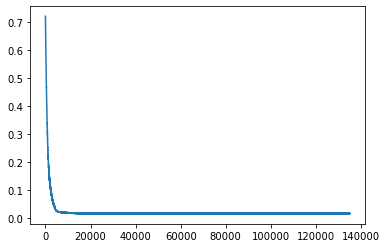

In [16]:
train_loss = np.load('EXP11-sample_dump/bottleneck_train_loss_second.npy')
plt.plot(train_loss)

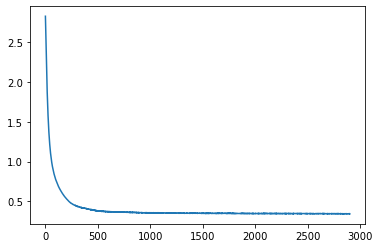

In [17]:
train_loss = np.load('EXP11-sample_dump/bottleneck_vali_loss_second.npy')
plt.plot(train_loss[100:])

(array([ 45144.,   8000.,   9095.,  14042., 310188.,  66119.,   1270.,
          1131.,   1042.,  45969.]),
 array([3.0157552e-27, 2.0000000e-01, 4.0000001e-01, 6.0000002e-01,
        8.0000001e-01, 1.0000000e+00, 1.2000000e+00, 1.4000000e+00,
        1.6000000e+00, 1.8000000e+00, 2.0000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

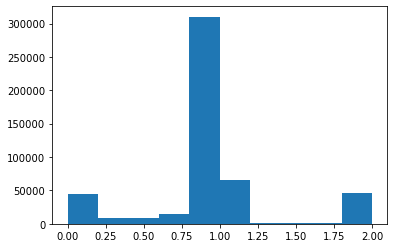

In [20]:
N_prod = 250        # number of products
Vec_Len = N_prod + 1

SAMPLE_AMOUNT = 2000

model = torch.load("EXP11-sample_dump/bottleneck_model_second.pth")
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    assort = AG.GenAssortment_Even(N_prod, 9/10)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = latent_scheme.prob_for_assortment(assort)


INPUT=torch.Tensor(INPUT)
OUTPUT = torch.Tensor(OUTPUT)

MODEL_OUT = model(INPUT)

RELATIVE_LOSS = nn.functional.l1_loss(OUTPUT, MODEL_OUT, size_average=False, reduce = False, reduction = None) / torch.clamp(OUTPUT, min = 1/Vec_Len)

losses = torch.clamp(torch.reshape(RELATIVE_LOSS,(-1,)), max=2).detach().numpy()

plt.hist(losses)